Project of deep learning for the certification of Jedha, bloc 4.

Author : Youenn PATAT

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

In [1]:
!pip install --upgrade tensorflow_hub

In [2]:
!pip install tensorflow_text=='2.15.0'

# 1) Preprocessing

## Loading data

In [1]:
import tensorflow as tf
import pathlib
import pandas as pd
import os
import io
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
tf.__version__

'2.15.1'

⚠️ This code works well only with this version of tensorflow, to use bert model and F1Score metric function of Keras.

Importation of the dataset and reading of it.

In [5]:
# Import dataset with Pandas
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding="utf-8", encoding_errors="ignore")
dataset.head()



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We keep only the columns that we need.

In [6]:
spam = dataset[["v1", "v2"]]
spam = spam.rename(columns={"v1": "label", "v2": "message"})
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
spam.shape

(5572, 2)

In [8]:
spam.isna().sum()

,0
label,0
message,0


There is no missing values.

## Preprocessing

In [9]:
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
# Import Spacy and english initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()

In [11]:
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

Cleaning of the text. We keep the alphanumeric characters, with the words seperate by only one space, in lowercase, and we tokenize it by lemmatization and english stop words.

In [12]:
spam["message_clean"] = spam["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
spam["message_clean"] = spam["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
spam["message_clean"] = spam["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

spam


,label,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win 750 pound prize...
5568,ham,Will _ b going to esplanade fr home?,b esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy week free


Verification that all values are string.

In [13]:
mask = spam.message_clean.apply(lambda x: type(x)==str)
mask.value_counts()


,count
message_clean,
True,5572


We encode the messages with keras tokenizer to have a value affected to each word. We keep only the first 1000 words more common.

In [14]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(spam.message_clean)
spam["message_encoded"] = tokenizer.texts_to_sequences(spam.message_clean)


Encoding the label `ham` or `spam` with label encoder to obtain a binary classification with `0` or `1`. And we put it in a new column : *`encoded_label`*

In [15]:
le = LabelEncoder()

encoded_label = le.fit_transform(spam['label'].tolist())
encoded_label = encoded_label.astype(np.float32) #needing to compute the f1-score with tf.keras if not it send error due to type
encoded_label

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [16]:
spam.insert(1, "encoded_label", encoded_label)
spam.head()

,label,encoded_label,message,message_clean,message_encoded
0,ham,0.0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 232, 446, 462, 934, 32, 50, 207, 935, 77, ..."
1,ham,0.0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[8, 197, 463, 290, 2, 1]"
2,spam,1.0,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 532, 659, 30, 1, 841, 424, 1, 1, ..."
3,ham,0.0,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 124, 148, 1, 2, 78]"
4,ham,0.0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[700, 20, 660, 128]"


Convertion of our dataset into a tensorflow dataset.

Tensorflow is incapable to create a tensor dataset based on lists, we will have to store all of our encoded texts into a single numpy array before creating the tensorflow dataset.
The problem is that not all our sequences are the same length, this is where the `tf.keras.preprocessing.sequence.pad_sequences` comes in handy, it will add zero padding at the beginning (`padding="pre"`) or at the end (`padding="post"`) of your sequences so they all have equal length.

In [17]:
max_len = 150
messages_pad = tf.keras.preprocessing.sequence.pad_sequences(spam.message_encoded, maxlen=max_len, padding='post')


Separation into a train and validation set, to keep `70%` for the train.

In [18]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(messages_pad,spam.encoded_label, stratify=spam.encoded_label, test_size=0.3)



Creation of a tensor dataset dor the train and validation.

In [19]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))


Shuffle on train set to add some ramdomizer, and batch by batches of 64 observation the bath datasets.

In [20]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)


In [21]:
 # Look at one batch
for message, label in train_batch.take(1):
  print(message, label)


tf.Tensor(
[[226 248  15 ...   0   0   0]
 [617   2 229 ...   0   0   0]
 [  1   1  55 ...   0   0   0]
 ...
 [ 85   1   1 ...   0   0   0]
 [  1  25  56 ...   0   0   0]
 [147 286 446 ...   0   0   0]], shape=(64, 150), dtype=int32) tf.Tensor(
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.], shape=(64,), dtype=float32)


# 2) Baseline : simple deep learning model

This first model is an embedding model following the architecture that we saw in the demonstration lecture.

In [22]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Layer od Input word embedding
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[max_len],name="embedding"),
                  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
                  # the zero padding)

                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),# this will pick the average for every word in the sentence
                  # along each dimension of the representation space.


                  # Layer Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Layer of output with the number of neurons on output equal to the number of class with linear function
                  tf.keras.layers.Dense(1, activation="sigmoid")
])


In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            8008      
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8169 (31.91 KB)
Trainable params: 8169 (31.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
spam['encoded_label'].value_counts()

,count
encoded_label,
0.0,4825
1.0,747


In [25]:
weights = 1/(spam['encoded_label']).value_counts()
weights = weights * len(spam)/5
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0.0: 0.23096373056994818, 1.0: 1.491834002677376}

Compilation of the model with the Adam optimizer, Means Square Error loss and metrics.

In [26]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.F1Score(threshold=0.5)])


Train of the model on 100 epochs.

In [27]:
basic_model = model.fit(train_batch,
                    epochs=100,
                    validation_data=val_batch,
                    class_weight=weights)


Epoch 1/100
61/61 [==============================] - 2s 12ms/step - loss: 0.2769 - binary_accuracy: 0.8677 - f1_score: 0.0480 - val_loss: 0.6787 - val_binary_accuracy: 0.8654 - val_f1_score: 0.0000e+00
Epoch 2/100
61/61 [==============================] - 1s 9ms/step - loss: 0.2751 - binary_accuracy: 0.8651 - f1_score: 0.0000e+00 - val_loss: 0.6620 - val_binary_accuracy: 0.8642 - val_f1_score: 0.0000e+00
Epoch 3/100
61/61 [==============================] - 1s 9ms/step - loss: 0.2711 - binary_accuracy: 0.9013 - f1_score: 0.4776 - val_loss: 0.6527 - val_binary_accuracy: 0.9199 - val_f1_score: 0.6298
Epoch 4/100
61/61 [==============================] - 1s 8ms/step - loss: 0.2630 - binary_accuracy: 0.9118 - f1_score: 0.5668 - val_loss: 0.6110 - val_binary_accuracy: 0.9336 - val_f1_score: 0.7132
Epoch 5/100
61/61 [==============================] - 0s 5ms/step - loss: 0.2480 - binary_accuracy: 0.9423 - f1_score: 0.7668 - val_loss: 0.5387 - val_binary_accuracy: 0.9378 - val_f1_score: 0.7360
Ep

### Evaluation of the first model

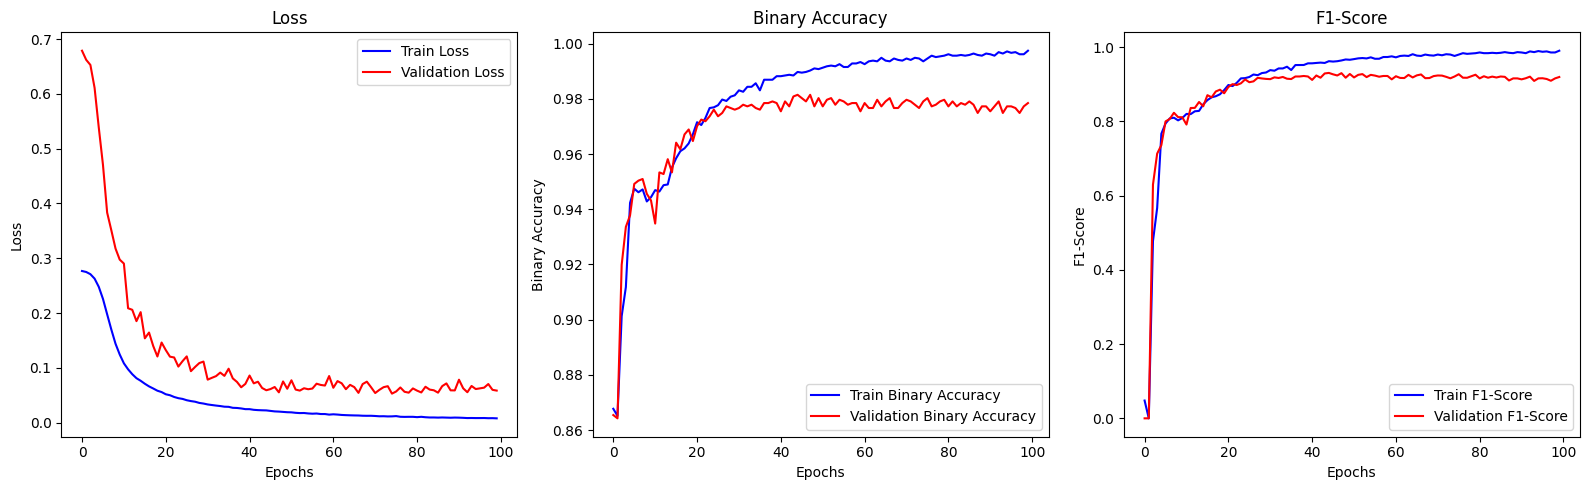

In [28]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns (4 subplots)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot Loss
axes[0].plot(basic_model.history["loss"], color="b", label="Train Loss")
axes[0].plot(basic_model.history["val_loss"], color="r", label="Validation Loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot Binary accuracy
axes[1].plot(basic_model.history["binary_accuracy"], color="b", label="Train Binary Accuracy")
axes[1].plot(basic_model.history["val_binary_accuracy"], color="r", label="Validation Binary Accuracy")
axes[1].set_title("Binary Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Binary Accuracy")
axes[1].legend()

# Plot f1-score
axes[2].plot(basic_model.history["f1_score"], color="b", label="Train F1-Score")
axes[2].plot(basic_model.history["val_f1_score"], color="r", label="Validation F1-Score")
axes[2].set_title("F1-Score")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("F1-Score")
axes[2].legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [29]:
ypred_train = (model.predict(train.batch(64)) > 0.5).astype("int32")
ypred_val = (model.predict(val.batch(64)) > 0.5).astype("int32")

27/27 [==============================] - 0s 2ms/step


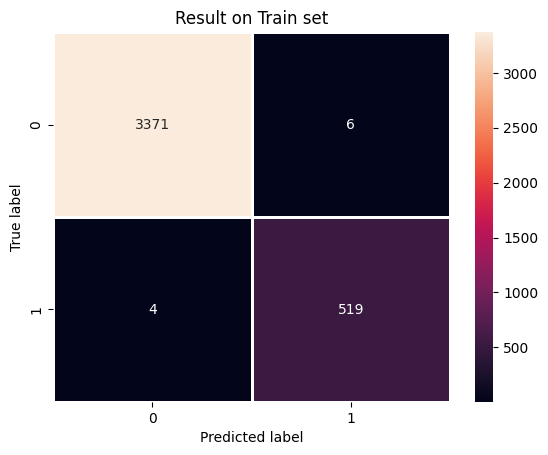

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Train set')
plt.show()


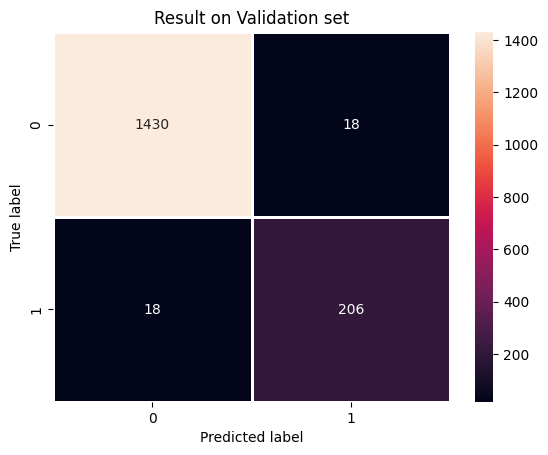

In [31]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Validation set')
plt.show()

In [32]:
loss_basic, accuracy_basic, f1_score_basic = model.evaluate(val_batch)

27/27 [==============================] - 0s 2ms/step - loss: 0.0588 - binary_accuracy: 0.9785 - f1_score: 0.9196


# 3) Transfer learning : More complex model

In [33]:
X_train, X_val, y_train, y_val = train_test_split(spam.message_clean,spam.encoded_label, stratify=spam.encoded_label, test_size=0.3)

train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).prefetch(tf.data.AUTOTUNE)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).prefetch(tf.data.AUTOTUNE)

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [34]:
import tensorflow_hub as hub
import tensorflow_text

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-2-h-128-a-2/versions/2",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768]
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]

out = tf.keras.layers.Dropout(0.2,name='dropout')(pooled_output)
out = tf.keras.layers.Dense(16,activation='relu')(out)
out = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(out)

bert_model=tf.keras.Model(inputs=[text_input],outputs=[out])

optimizer= tf.keras.optimizers.Adam()

bert_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.F1Score(threshold=0.5)])



In [35]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [36]:
history_bert_model = bert_model.fit(train_batch,
                    epochs=100,
                    validation_data=val_batch)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


61/61 [==============================] - 33s 462ms/step - loss: 0.2628 - binary_accuracy: 0.8949 - f1_score: 0.4368 - val_loss: 0.1748 - val_binary_accuracy: 0.9396 - val_f1_score: 0.7518
Epoch 2/100
61/61 [==============================] - 27s 450ms/step - loss: 0.1738 - binary_accuracy: 0.9336 - f1_score: 0.7310 - val_loss: 0.1498 - val_binary_accuracy: 0.9462 - val_f1_score: 0.8052
Epoch 3/100
61/61 [==============================] - 28s 451ms/step - loss: 0.1451 - binary_accuracy: 0.9451 - f1_score: 0.7864 - val_loss: 0.1358 - val_binary_accuracy: 0.9551 - val_f1_score: 0.8252
Epoch 4/100
61/61 [==============================] - 27s 446ms/step - loss: 0.1414 - binary_accuracy: 0.9444 - f1_score: 0.7836 - val_loss: 0.1281 - val_binary_accuracy: 0.9581 - val_f1_score: 0.8333
Epoch 5/100
61/61 [==============================] - 26s 436ms/step - loss: 0.1300 - binary_accuracy: 0.9513 - f1_score: 0.8123 - val_loss: 0.1221 - val_binary_accuracy: 0.9617 - val_f1_score: 0.8559
Epoch 6/100


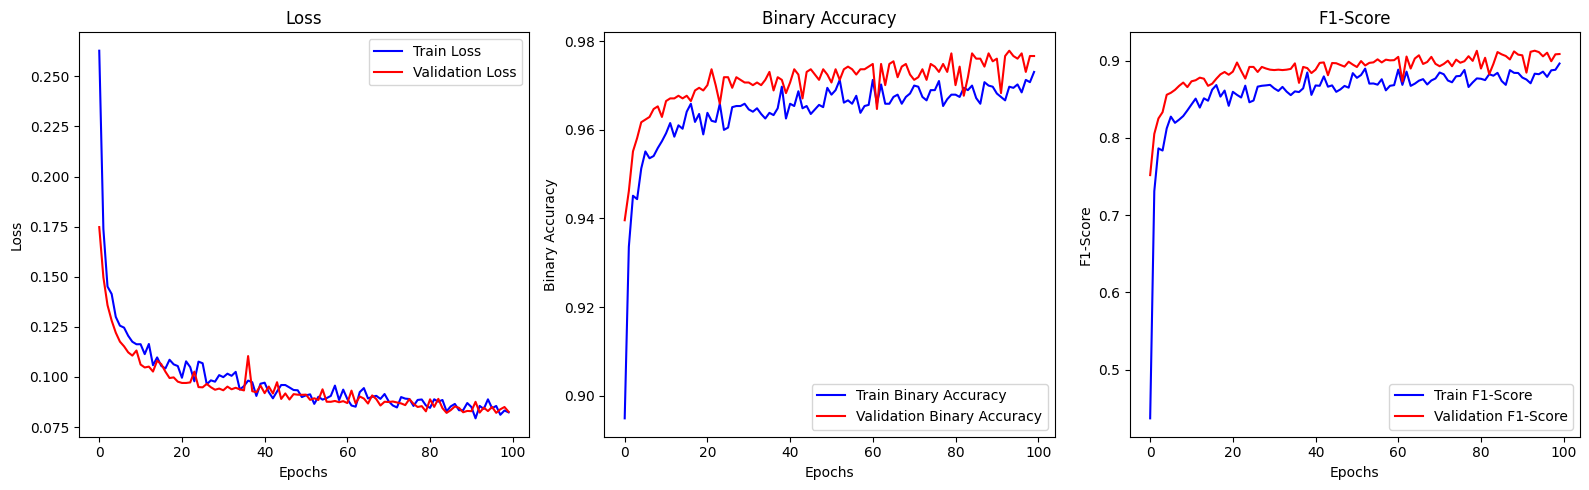

In [37]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns (4 subplots)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot Loss
axes[0].plot(history_bert_model.history["loss"], color="b", label="Train Loss")
axes[0].plot(history_bert_model.history["val_loss"], color="r", label="Validation Loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot Binary accuracy
axes[1].plot(history_bert_model.history["binary_accuracy"], color="b", label="Train Binary Accuracy")
axes[1].plot(history_bert_model.history["val_binary_accuracy"], color="r", label="Validation Binary Accuracy")
axes[1].set_title("Binary Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Binary Accuracy")
axes[1].legend()

# Plot f1-score
axes[2].plot(history_bert_model.history["f1_score"], color="b", label="Train F1-Score")
axes[2].plot(history_bert_model.history["val_f1_score"], color="r", label="Validation F1-Score")
axes[2].set_title("F1-Score")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("F1-Score")
axes[2].legend()


# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [38]:
ypred_train = (bert_model.predict(train.batch(64)) > 0.5).astype("int32")
ypred_val = (bert_model.predict(val.batch(64)) > 0.5).astype("int32")

27/27 [==============================] - 8s 278ms/step


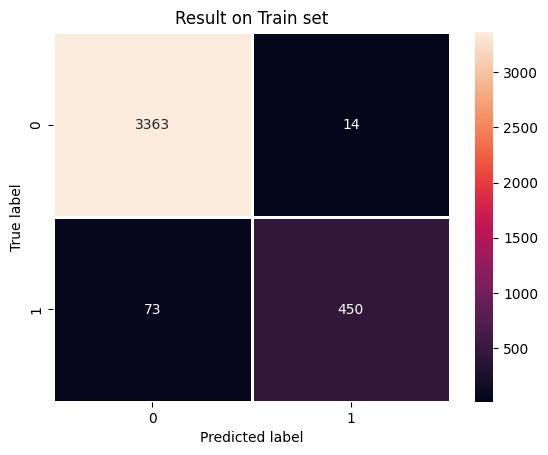

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mtx = confusion_matrix(y_train, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Train set')
plt.show()


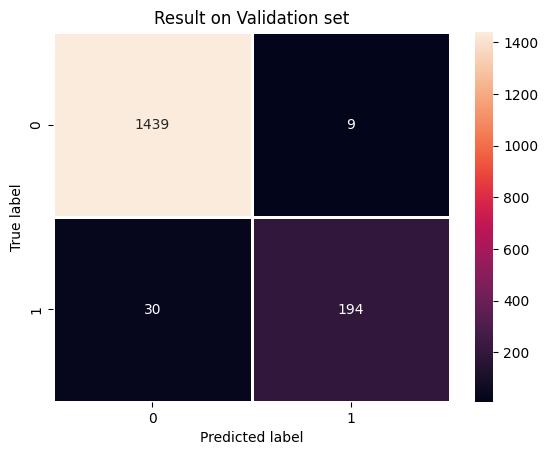

In [40]:
mtx = confusion_matrix(y_val, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Validation set')
plt.show()

In [41]:
loss_bert, accuracy_bert, f1_score_bert = bert_model.evaluate(val_batch)

27/27 [==============================] - 9s 323ms/step - loss: 0.0826 - binary_accuracy: 0.9767 - f1_score: 0.9087


# 4) Performances comparison

In [42]:
results = pd.DataFrame({"Model" : ["Simple Model", "Bert Model"],
                        "Loss" : [loss_basic, loss_bert],
                        "Accuracy" : [accuracy_basic, accuracy_bert],
                        "F1-Score" : [f1_score_basic[0], f1_score_bert[0]]
                        })

results

,Model,Loss,Accuracy,F1-Score
0,Simple Model,0.058759,0.978469,0.919643
1,Bert Model,0.082612,0.976675,0.908665


In [43]:
results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Score")

print(results_melted)

          Model    Metric     Score
0  Simple Model      Loss  0.058759
1    Bert Model      Loss  0.082612
2  Simple Model  Accuracy  0.978469
3    Bert Model  Accuracy  0.976675
4  Simple Model  F1-Score  0.919643
5    Bert Model  F1-Score  0.908665


In [ ]:
import plotly.express as px

# Create grouped bar chart
fig = px.bar(results_melted, x="Model", y="Score", color="Metric",
             barmode="group",  # Group bars next to each other
             text=results_melted["Score"].round(3),  # Add value labels
             color_discrete_map={"Loss": "red", "Accuracy": "blue", "F1-Score": "orange"}  # Custom colors
            )

# Customize layout
fig.update_layout(
    title="Comparison of Model Scores",
    xaxis_title="Models",
    yaxis_title="Scores",
    legend_title="Metrics",
    height=500, width=800
)

fig.show()

![performance comparison](performance_comparison.png)

* The both models have good performances.
* For this specific case, our simple model seems better, high scores and fast. Bert model is good too but longer to compute. But in a general case, Bert should be better, due to the higher stability of the score (less differences between test & val than for the simple model).
* Simple can be better sometime.

## In perspective :

* Do fine tuning with bert model to improve it.
* Try other models